In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ipywidgets
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimation
from IPython.display import display

# Explanation

Here we show the code used to classify the experimental patterns. We used a semi-manual approach as detailed in the supplementary material of the paper. 
Roughly, we use a cosine expansion 
$$\rho(x) \approx \sum_{k=0}^K a_k \cos (\pi k/\ell x)$$
and base the classification on the values of the $a_k$, in case there is one dominant mode. If the two modes with largest contribution are clsoe to each other in magnitude, we do a manual assessment of the pattern.

Density profiles with too low of an average density are classified as `no pattern'. 

To classify the whole bar, we take frame $f_0 + 160$, where $f_0$ is the frame corresponding to 200 minutes from plating. 

In [2]:
### Load in the descriptors of the bar data
allbardata = pd.read_csv("data/bardata_allexperiments_extended.csv")

#### experiment and bar labels as strings
allbardata['Experiment'] = allbardata['Experiment'].astype(str)
allbardata['Bar'] = allbardata['Bar'].astype(str)
allbardata.set_index(['Experiment', 'Bar'], inplace=True)

###### get the intended printed length (these are multiples of 10 micron. The 1.084 comes from the resolution of the image (pixels per micron))
allbardata['Length_micron'] = np.round((allbardata['Length']/1.084/20))*20

##### drop the square bars and the very long ones
allbardata.drop( allbardata.index[allbardata['Length_micron']==40], inplace=True)
allbardata.drop( allbardata.index[allbardata['Length_micron']>330], inplace=True)

#### Load in all the density profiles
### and do light processing (smoothing)
avgn = 11 # averaging window

density_profiles = {}
for exp, bar in allbardata.index:
    filename = f'data/bars_density_profiles/{exp}_bar{bar}_threxp_densityhigh_n.txt'
    xrho = np.loadtxt(filename) ## first row: x values, the rest is density per timepoint
    x = xrho[0]
    rho = xrho[1:]
    rho_smooth = np.zeros_like(rho)

    for i in range(rho.shape[1]): #### iterate over spatial positions
        rh_extended = np.hstack((avgn//2 * [rho[0,i]], rho[:,i], avgn//2 * [rho[-1,i]]))
        rho_smooth[:,i] = np.convolve(rh_extended, np.ones(avgn)/avgn, mode='same')[avgn//2: - avgn//2+1]

    ### save to dictionary
    density_profiles[(exp,bar)] = (x,rho,rho_smooth)



## Automatic classification based on cosine spectrum

In [3]:
def get_cosine_spectrum(x, u, L=None, nmax=None):
    """Return the cosine expansion"""
    if nmax==None:
        nmax = len(u)//2
    if L==None:
        L=x[-1]

    A = np.zeros((len(x), nmax))
    for i in range(nmax):
        A[:,i] = np.cos(np.pi/L*i*x) ### NOT 2pi, but pi, because we want also the 'half modes'

    y = np.linalg.lstsq(A, u, rcond=None)[0]
    return y
def classify_dominant_mode(k, a):
    ### k is wavenumber, a coefficient
    ### return 1 for polarized, 2 for middle peak, 3 for two peaks, 4 for more peaks
    if k==1:
        return 1
    elif k==2 and a<0:
        return 2
    elif k==2 or k==3 or (k==4 and a<0):
        return 3
    else:
        return 4
        
def classify_pattern_from_spectrum(y):
    ### y is the spectrum
    ### we assume that y[0] = 0, i.e. we subtracted the mean before computing the spectrum
    y[0]=0
    i1, i2 = np.argsort(y**2)[-2:] ### indices of two dominant modes
    
    if abs(y[i2])> 1.5*abs(y[i1]):
        ##### single dominant mode -> classify based on dominant mode
        pgroup = classify_dominant_mode(i2, y[i2])
        return pgroup, True
    else:
        #### to do manually
        return 0, False

In [14]:
###### calculate the pattern group for a single frame for each bar
new_rows = []
for exp, bar in allbardata.index:
    x,rho,rho_smooth = density_profiles[(exp, bar)]
    
    L, frame0 = allbardata.loc[(exp, bar), ['Length_micron', 'frame0']]
    frame0=int(frame0)
    
    for frame in [frame0+160]:
        u = rho_smooth[frame]
        amplitude = np.max(u) - np.min(u)
        rhomean = np.mean(u)
        rhostd = np.std(u)
        
        y = get_cosine_spectrum(x, u-np.mean(u), L=L,nmax=len(u)//2)
        
        if np.sum(y[1:]**2) <1e-10:
            #### no power in the modes - flat profile
            pgroup = 0
            auto_classified=True
        else:
            pgroup, auto_classified = classify_pattern_from_spectrum(y)
        
        new_rows.append([exp, bar, L, frame-frame0, rhomean,rhostd, amplitude, pgroup, auto_classified])
dfc = pd.DataFrame(new_rows, columns=['Experiment','Bar','L','delta_frame',\
                                      'avg_rho', 'std_rho', 'amplitude', 'pgroup', 'auto_classified'])

## bars with low density -> no pattern
inds_lowdensity = dfc.index[dfc['avg_rho'] < 0.2]
dfc.loc[inds_lowdensity, 'auto_classified']=True
dfc.loc[inds_lowdensity, 'pgroup']=0

#dfc.to_csv("data_for_figures/experimental_data/experiment_pattern_classification.csv")

In [5]:
to_check = dfc.index[dfc['auto_classified']==False]
print("Bars still to classify: {}".format(len(to_check)))


Bars still to classify: 54


### Manual classification of the rest

We set up an interactive widget so we can scroll through the non-classified bars.

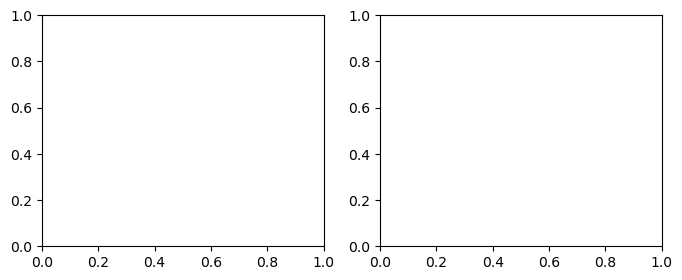

IntSlider(value=0, max=54)

Text(value='', description='Input:', placeholder='Enter pgroup')

Button(description='Save', style=ButtonStyle())

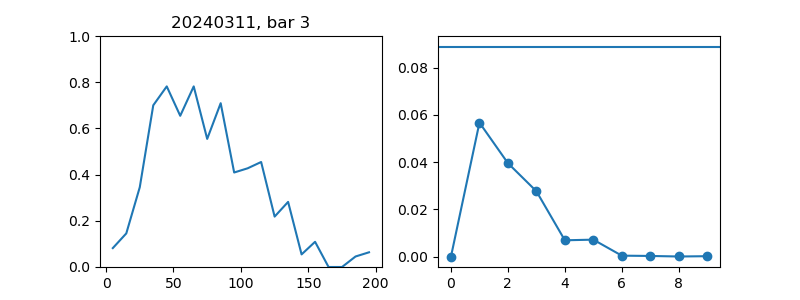

In [6]:
%matplotlib ipympl
input_dict = {} #### will contain the manually determined pattern groups

fig, axes = plt.subplots(1, 2, figsize=(8,3))

# Slider for index of the bar to classify
dropdown1 = ipywidgets.IntSlider(
    min=0, max= len(to_check), step=1
)

# Create an input field where we can enter the group
input_field = ipywidgets.Text(
    value='',
    placeholder='Enter pgroup',
    description='Input:',
    disabled=False
)

# Create a button to save
button = ipywidgets.Button(description="Save")

# Define the function to update the plot based on drop-down values
def update_plot(change):
    exp, bar = dfc.loc[to_check[dropdown1.value], ['Experiment','Bar']]
    x,rho,rho_smooth = density_profiles[(exp, bar)]
    L, frame0 = allbardata.loc[(exp, bar), ['Length_micron', 'frame0']]
    frame0=int(frame0)
    u = rho_smooth[frame0+160]
    y = get_cosine_spectrum(x, u-np.mean(u), L=L,nmax=len(u)//2)
    # Clear the current plot
    for ax in axes:
        ax.clear()
    
    axes[0].plot(x, u)
    axes[0].set_ylim(0,np.maximum(1, np.max(u)+0.1))
    axes[0].set_title(f'{exp}, bar {bar}')
    axes[1].plot(y**2, 'o-') ## spectrum
    axes[1].axhline(y[np.argsort(y**2)[-2]]**2*1.5**2) #### if everything was correct, the spectrum should lie completely below this line
    fig.canvas.draw()

# Attach the update function to the drop-down menus
dropdown1.observe(update_plot, names='value')

# Define the function to be called when the button is clicked
def on_button_clicked(b):
    value = input_field.value
    exp, bar = dfc.loc[to_check[dropdown1.value], ['Experiment','Bar']]

    input_dict[(exp, bar)] = value
    print(f"Value saved: {value}")
    #print(f"Dictionary: {input_dict}")

# Attach the function to the button's click event
button.on_click(on_button_clicked)

# Display the figure, drop-down menus, input field, and button
display(fig, dropdown1, input_field, button)
update_plot(None)


In [15]:
### add this to dataframe
dfc.set_index(['Experiment','Bar'], inplace=True)
for (exp, bar), pgroup in input_dict.items():
    dfc.loc[(exp,bar), 'pgroup'] = int(pgroup)


In [27]:
# save
dfc.to_csv("../data_for_figures/experimental_data/experiment_pattern_classification_semimanual.csv")